<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/tutorials/generative/neural-style-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

In [26]:
import os
import time
import functools
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
# load compressed model
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
# customize matplotlib's runtime configuration settings
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 12)

Download content and style reference images.

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 0us/step


Before demonstrating style transfer algorithm, visualize both content images and style reference images.

In [19]:
# define a function to load an image and limit its dimention to 512 pixels
def load_image(path_to_image):
  max_dim = 512
  img = tf.io.read_file(path_to_image)
  img = tf.image.decode_image(img, channels=3, dtype=tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], dtype=tf.float32)
  scale = max_dim / max(shape)
  new_shape = tf.cast(shape*scale, tf.int32)

  img = tf.image.resize(images=img, size=new_shape)
  # for 1 batch size
  img = img[tf.newaxis, :]
  return img

In [24]:
def display_image(image, title=None):
  # shrink image size from (batch_size, height, width, channels) -> (height, width, channels)
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis('off')

  if title:
    plt.title(title)

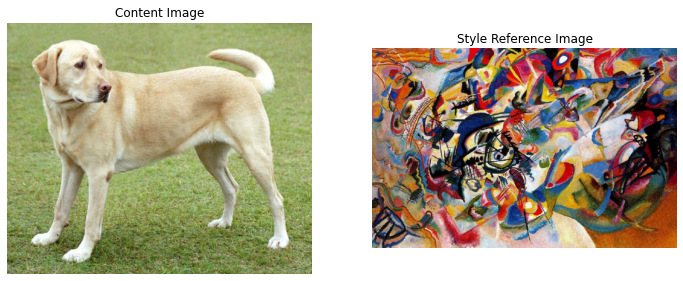

In [25]:
plt.subplot(1, 2, 1)
content = load_image(content_path)
display_image(content, "Content Image")

plt.subplot(1, 2, 2)
style = load_image(style_path)
display_image(style, "Style Reference Image")

## Fast Style Transfer using TensorFlow Hub Model

Since the result of style transfer TensorFlow Hub Model is a list of tensor of shape (batch_size, height, width, channels), a function ```tensor2image``` is required.

In [38]:
def tensor2image(tensor):
  # np.uint8 has range of [0, 255] which covers full pixel value range
  tensor = np.array(tensor*255, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    # if batch_size == 1
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  # create an image from a given object (tensor)
  return PIL.Image.fromarray(tensor)

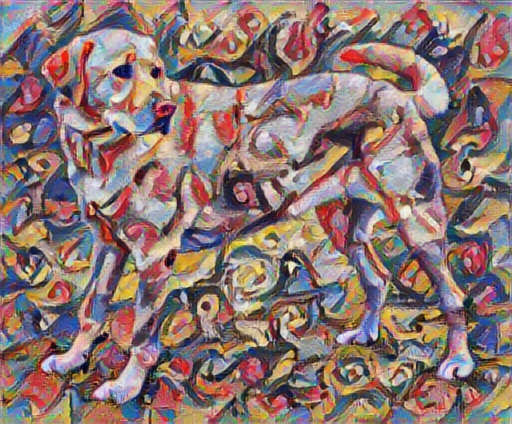

In [39]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
# get a transferred image from a list of result(s)
transferred_image = hub_model(tf.constant(content), tf.constant(style))[0]
tensor2image(transferred_image)